<a href="https://colab.research.google.com/github/mia19reynolds/FinalProject/blob/main/CINPredicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Model to Predict CIN

## Problem formulation

This portion of the project investigates the classification task of predicting whether a student is a Child in Need (CIN) from their demographics and school record attributes.

The synthetic data used contain the following **features:**


*   **Year:** Year group (e.g. Year 7, Year 8, … Year 11)
*   **Gender:** Male / Female
*   **Ethnicity:** e.g. “White – White British”, “Mixed – Any other Mixed background”, “Unclassified”, etc. 19 defined ethnicities
*   **FSM:** Free School Meal eligibility (FSM_Eligible / FSM_Not_Eligible)
*  **SEN:** Special Educational Needs status (No SEN / EHC plans / SEN)
*   **Suspended:** Whether ever suspended (Suspended / Not Suspended)
*   **Attendance:** Attendance rate (percentage of days present)
*   **CIN:** Children in Need status (No CIN / CIN)

**Target:**
*   **CIN:** Children in Need status (No CIN / CIN)

## Imports

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np

# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt

import seaborn as sns

## Load data

In [4]:
student_synth_df = pd.read_csv('/content/drive/MyDrive/Synthetic Student Data Derbyshire/student_profiles_-2.csv')

## Establishing a Baseline

Here, a baseline model is established using scikit-learn's `DummyClassifier` to establish a simple perfomance floor.

In [5]:
# Features and target
X = student_synth_df.drop(columns=['CIN'])
y = student_synth_df['CIN']

# Stratified random guessing baseline
dummy = DummyClassifier(strategy="stratified", random_state=42)
scores = cross_val_score(dummy, X, y, cv=5, scoring="accuracy")

print(f"DummyClassifier: {scores.mean():.3f}")

DummyClassifier: 0.939


In [6]:
dummy.fit(X, y)
y_pred = dummy.predict(X)
y_proba = dummy.predict_proba(X)[:,1]  # for ROC-AUC

print("Accuracy: ", (y_pred == y).mean())
print("Balanced accuracy: ", balanced_accuracy_score(y, y_pred))
print("ROC-AUC: ", roc_auc_score(y.map({'No CIN':0,'CIN':1}), y_proba))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))


Accuracy:  0.9371461750616925
Balanced accuracy:  0.5051348791086828
ROC-AUC:  0.4948651208913172
Confusion matrix:
 [[   58  1296]
 [ 1302 38678]]


### Evaluation of Baseline Model

Running our stratified `DummyClassifier`, we observe:

- **Accuracy**: 0.937  
  This high value largely reflects class imbalance (most students are “No CIN”).  
- **Balanced Accuracy**: 0.4999  
  Indicates the model is no better than random when accounting for both classes equally.  
- **ROC-AUC**: 0.50
  Confirms that our dummy model has zero discriminative power.  

## Investigate different models

### Prepare Data

The data is prepared and split into test/train sets of 80:20 proportion. The attributes are put into groups of categorical or numeric.

In [7]:
df = student_synth_df.copy()
df['Attendance'] = pd.to_numeric(df['Attendance'], errors='coerce').fillna(0)

# X/y split
X = df.drop(columns=['CIN'])
y = df['CIN'].map({'No CIN': 0, 'CIN': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Categorical vs numeric
cat_cols = ['Year', 'Gender', 'Ethnicity', 'FSM', 'SEN']
num_cols = ['Attendance']

# Encoders/scaler on training set
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_cols])

scaler = StandardScaler()
scaler.fit(X_train[num_cols])

# Transform train and test
X_train_enc = pd.DataFrame(ohe.transform(X_train[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_train.index)
X_test_enc  = pd.DataFrame(ohe.transform(X_test[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_test.index)

X_train_num = pd.DataFrame(scaler.transform(X_train[num_cols]),
                           columns=num_cols,
                           index=X_train.index)
X_test_num  = pd.DataFrame(scaler.transform(X_test[num_cols]),
                           columns=num_cols,
                           index=X_test.index)

# Final arrays
X_train_pre = np.hstack([X_train_enc, X_train_num])
X_test_pre  = np.hstack([X_test_enc,  X_test_num])

In [8]:
# Initialize an empty results DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'
])


# Function to fit and evuate models
def eval_model(name, model):
    # Fit and predict
    model.fit(X_train_pre, y_train)
    y_pred = model.predict(X_test_pre)
    y_proba = model.predict_proba(X_test_pre)[:, 1]

    # Compute metrics
    acc     = accuracy_score(y_test, y_pred)
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    roc     = roc_auc_score(y_test, y_proba)
    pr, rc, _ = precision_recall_curve(y_test, y_proba)
    pr_auc  = auc(rc, pr)

    # Append to results DataFrame
    global results_df
    results_df.loc[len(results_df)] = [
        name, acc, prec, rec, f1, roc, pr_auc
    ]

    # Display
    display(results_df.sort_values('ROC-AUC', ascending=False))

### Random Forest

In [9]:
eval_model(
    'RandomForest',
    RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,RandomForest,0.999274,0.996255,0.98155,0.988848,0.999997,0.999918


### LightGBM

In [10]:
eval_model(
    'LightGBM',
    LGBMClassifier(n_estimators=300, is_unbalance=True, random_state=42, verbose=-1,log_level='error' )
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.999879,1.000000,0.99631,0.998152,1.000000,0.999986
0,RandomForest,0.999274,0.996255,0.98155,0.988848,0.999997,0.999918


### XGBoost

In [11]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
eval_model(
    'XGBoost',
    XGBClassifier(
        n_estimators=300,
        scale_pos_weight=ratio,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.999879,1.000000,0.99631,0.998152,1.000000,0.999986
2,XGBoost,0.999879,0.996324,1.00000,0.998158,0.999999,0.999959
0,RandomForest,0.999274,0.996255,0.98155,0.988848,0.999997,0.999918


### CatBoost

In [12]:
X_train_cb = pd.concat([X_train_enc, X_train_num], axis=1)
X_test_cb  = pd.concat([X_test_enc,  X_test_num], axis=1)

eval_model(
    'CatBoost',
    CatBoostClassifier(
        iterations=400,
        learning_rate=0.1,
        depth=6,
        auto_class_weights='Balanced',
        verbose=False,
        random_state=42
    )
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.999879,1.000000,0.99631,0.998152,1.000000,0.999986
3,CatBoost,0.999758,0.996310,0.99631,0.996310,0.999999,0.999973
2,XGBoost,0.999879,0.996324,1.00000,0.998158,0.999999,0.999959
0,RandomForest,0.999274,0.996255,0.98155,0.988848,0.999997,0.999918


## Model Comparison

From the validation results across all four models the following was found:

*   LightGBM edges out the pack with a perfect ROC-AUC of 1.00, PR-AUC of 0.99999, and an F1-score of 0.998.
*  XGBoost is virtually identical (ROC-AUC = 1.00, PR-AUC= 0.99996, F1 ≈ 0.998).
*   CatBoost follows closely (ROC-AUC = 0.999999, PR-AUC = 0.99997, F1 = 0.996).
*   Random Forest also performs exceptionally (ROC-AUC = 1.00, PR-AUC = 0.99992, F1 = 0.989) but slightly trails the other models.


Overall, it seems that LightGBM model is the strongest model for flagging CIN cases. However the near perfect scores show that it is likely the models are using certain atttributes as a proxy for CIN. These scores are near impossible in reality.






## Investigate Attendance Correlation

To investigate the near perfect scores of the LightGBM, features and their use are loaded.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 10 features by importance (with Attendance):
Attendance                         1627
SEN_No SEN                          394
Ethnicity_Asian - Bangladeshi       371
FSM_FSM_Eligible                    330
Ethnicity_White - White British     308
Year_Year 7                         308
Year_Year 9                         255
Ethnicity_Black - Black African     186
Year_Year 10                        166
Year_Year 11                        159
dtype: int32


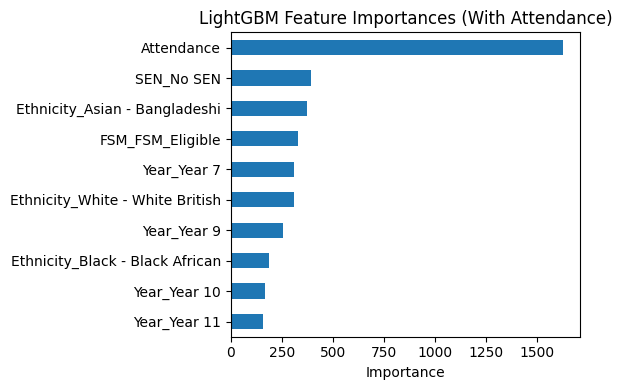

In [13]:
# Feature name list categories plus attendance
feature_names = list(ohe.get_feature_names_out(cat_cols)) + ['Attendance']

# Refit the evaluated LightGBM
lgb_full = LGBMClassifier(
    n_estimators=300,
    is_unbalance=True,
    random_state=42,
    verbose=-1,
    log_level='error'
)
lgb_full.fit(X_train_pre, y_train)

# Sort importances
importances = pd.Series(lgb_full.feature_importances_, index=feature_names)
top10 = importances.sort_values(ascending=False).head(10)

print("Top 10 features by importance (with Attendance):")
print(top10)

# Plot
plt.figure(figsize=(6,4))
top10.sort_values().plot(kind='barh')
plt.title("LightGBM Feature Importances (With Attendance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


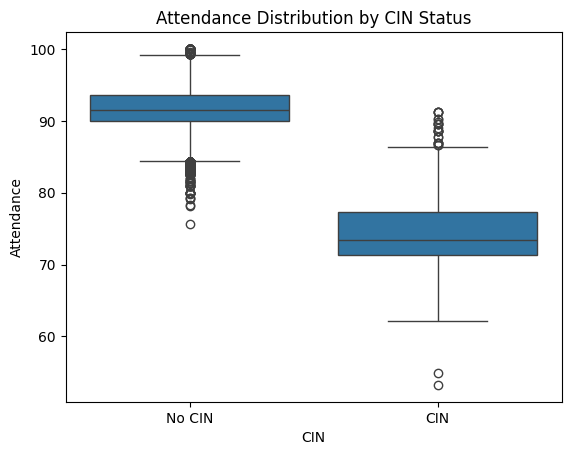

          count       mean       std        min        25%        50%  \
CIN                                                                     
CIN      1354.0  74.100000  5.067014  53.255601  71.271532  73.382353   
No CIN  39980.0  91.401225  2.734762  75.624455  89.936674  91.547496   

              75%         max  
CIN                            
CIN     77.377484   91.204967  
No CIN  93.646110  100.000000  


In [16]:
# Box‐plot of attendance by CIN class
sns.boxplot(x=df['CIN'], y=df['Attendance'])
plt.title("Attendance Distribution by CIN Status")
plt.show()

# Group means
print(df.groupby('CIN')['Attendance'].describe())


### Feature Importance Comments

The bar chart makes it abundantly clear that attendance is the single strongest driver of the model's performance. All other demographic and categorical attributes - while not irrelevant - are overshadowed. This confirms the concern around single attribute reliance. To obtain a realistic model that truly learns from student characteristics rather than a proxy for CIN status, we must drop Attendance and repeat our modeling pipeline on the reduced feature set.

# Model Investigation (without Attendance)

As decided above, attendance is dropped before repeating the process.

In [17]:
student_synth_df = student_synth_df.drop(columns=['Attendance'])

## Establishing a Baseline

Here, a baseline model is established using scikit-learn's `DummyClassifier` to establish a simple perfomance floor.

In [18]:
# Features and target
X = student_synth_df.drop(columns=['CIN'])
y = student_synth_df['CIN']

# Stratified random guessing baseline
dummy = DummyClassifier(strategy="stratified", random_state=42)
scores = cross_val_score(dummy, X, y, cv=5, scoring="accuracy")

print(f"DummyClassifier: {scores.mean():.3f}")

DummyClassifier: 0.939


In [19]:
dummy.fit(X, y)
y_pred = dummy.predict(X)
y_proba = dummy.predict_proba(X)[:,1]  # for ROC-AUC

print("Accuracy: ", (y_pred == y).mean())
print("Balanced accuracy: ", balanced_accuracy_score(y, y_pred))
print("ROC-AUC: ", roc_auc_score(y.map({'No CIN':0,'CIN':1}), y_proba))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))


Accuracy:  0.9371461750616925
Balanced accuracy:  0.5051348791086828
ROC-AUC:  0.4948651208913172
Confusion matrix:
 [[   58  1296]
 [ 1302 38678]]


### Evaluation of Baseline Model

Running our stratified `DummyClassifier`, we observe:

- **Accuracy**: 0.937  
  This high value largely reflects class imbalance (most students are “No CIN”).  
- **Balanced Accuracy**: 0.505
  Indicates the model is no better than random when accounting for both classes equally.  
- **ROC-AUC**: 0.500  
  Confirms that our dummy model has zero discriminative power.  

## Investigate different models

### Prepare Data

In [20]:
df = student_synth_df.copy()

# X/y split
X = df.drop(columns=['CIN'])
y = df['CIN'].map({'No CIN': 0, 'CIN': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Categorical vs numeric
cat_cols = ['Year', 'Gender', 'Ethnicity', 'FSM', 'SEN']

# Encoders on training set
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_cols])

# Transform train and test
X_train_enc = pd.DataFrame(ohe.transform(X_train[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_train.index)
X_test_enc  = pd.DataFrame(ohe.transform(X_test[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_test.index)

# Final arrays
X_train_pre = X_train_enc.values
X_test_pre  = X_test_enc.values

In [21]:
# Initialize an empty results DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'
])


# Function to fit and evuate models
def eval_model(name, model):
    # Fit & predict
    model.fit(X_train_pre, y_train)
    y_pred = model.predict(X_test_pre)
    y_proba = model.predict_proba(X_test_pre)[:, 1]

    # Compute metrics
    acc     = accuracy_score(y_test, y_pred)
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    roc     = roc_auc_score(y_test, y_proba)
    pr, rc, _ = precision_recall_curve(y_test, y_proba)
    pr_auc  = auc(rc, pr)

    # Append to results DataFrame
    global results_df
    results_df.loc[len(results_df)] = [
        name, acc, prec, rec, f1, roc, pr_auc
    ]

    # Display
    display(results_df.sort_values('ROC-AUC', ascending=False))

### Random Forest

In [22]:
eval_model(
    'RandomForest',
    RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,RandomForest,0.749728,0.07833,0.616236,0.138993,0.730449,0.174982


### LightGBM

In [23]:
eval_model(
    'LightGBM',
    LGBMClassifier(n_estimators=300, is_unbalance=True, random_state=42, verbose=-1,log_level='error' )
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.740898,0.084037,0.697417,0.150000,0.773404,0.270591
0,RandomForest,0.749728,0.078330,0.616236,0.138993,0.730449,0.174982


### XGBoost

In [24]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
eval_model(
    'XGBoost',
    XGBClassifier(
        n_estimators=300,
        scale_pos_weight=ratio,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.740898,0.084037,0.697417,0.150000,0.773404,0.270591
2,XGBoost,0.741744,0.079802,0.653137,0.142226,0.742755,0.248416
0,RandomForest,0.749728,0.078330,0.616236,0.138993,0.730449,0.174982


### CatBoost

In [25]:
X_train_cb = pd.concat([X_train_enc, X_train_num], axis=1)
X_test_cb  = pd.concat([X_test_enc,  X_test_num], axis=1)

eval_model(
    'CatBoost',
    CatBoostClassifier(
        iterations=400,
        learning_rate=0.1,
        depth=6,
        auto_class_weights='Balanced',
        verbose=False,
        random_state=42
    )
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.740898,0.084037,0.697417,0.150000,0.773404,0.270591
3,CatBoost,0.739809,0.082222,0.682657,0.146767,0.763086,0.264792
2,XGBoost,0.741744,0.079802,0.653137,0.142226,0.742755,0.248416
0,RandomForest,0.749728,0.078330,0.616236,0.138993,0.730449,0.174982


## Model Comparison

From the validation results across all four models the following was found:

*   LightGBM edges out the pack with a perfect ROC-AUC of 0.773, PR-AUC of 0.271, and an F1-score of 0.150.
*   CatBoost follows closely (ROC-
AUC = 0.763, PR-AUC = 0.265, F1 = 0.147).
*  XGBoost follows (ROC-AUC = 0.743, PR-AUC= 0.248, F1 ≈ 0.142).
*   Random Forest falls last (ROC-AUC = 0.730, PR-AUC = 0.175, F1 = 0.139).


Even without attendance, the models outperform random guessing (ROC-AUC > 0.50). LightGBM is the best performer on the attendance-free data, so it will be used for further tuning and threshold optimization.






## Hyperparameter tuning for LightGBM

As LightGBM has been identified as the best model out of those investigated, in this section it is tuned and evaluated.

Here, `RandomSearchCV` is used over CatBoosts's hyperameters with the aim to optimise the CatBoost classifiers ROC-AUC.

In [26]:
# Base estimator
lgb = LGBMClassifier(
    is_unbalance=True,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)


# Parameter distributions
param_dist = {
    'iterations': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

search_lgb = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=False
)


### Inspect best parameters

Here, the randomized search is fitted on the training data to find the best cross-validation score to the relevant hyperparameter values.

In [27]:
search_lgb.fit(X_train_pre, y_train)

print("Best CV ROC-AUC:", search_lgb.best_score_)
print("Best parameters:")
for k, v in search_lgb.best_params_.items():
    print(f" • {k}: {v}")

best_lgb = search_lgb.best_estimator_


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best CV ROC-AUC: 0.8253980191793016
Best parameters:
 • learning_rate: 0.01
 • l2_leaf_reg: 7
 • iterations: 400
 • depth: 8
 • border_count: 128


### Retrain Model and Evaluate

In [28]:
# Retrain on full training set
best_lgb.fit(X_train_pre, y_train)

# Predict on hold-out test
y_pred  = best_lgb.predict(X_test_pre)
y_proba = best_lgb.predict_proba(X_test_pre)[:,1]

# Standard metrics
print(classification_report(y_test, y_pred, target_names=['No CIN','CIN']))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# PR-AUC
prec, rec, _ = precision_recall_curve(y_test, y_proba)
print("PR-AUC:", auc(rec, prec))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

      No CIN       0.98      0.96      0.97      7996
         CIN       0.25      0.39      0.31       271

    accuracy                           0.94      8267
   macro avg       0.62      0.68      0.64      8267
weighted avg       0.96      0.94      0.95      8267

Accuracy: 0.9415749364944962
Precision: 0.2511737089201878
Recall: 0.3948339483394834
F1 Score: 0.30703012912482064
ROC-AUC: 0.8081817661598327
PR-AUC: 0.31690897298784737
Confusion Matrix:
 [[7677  319]
 [ 164  107]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
# Base estimator
cbc = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=False,
    random_state=42
)


# Parameter distributions
param_dist = {
    'iterations': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

search_cbc = RandomizedSearchCV(
    estimator=cbc,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=False
)


### Optimal Threshold for Best Model

Optimal threshold: 0.579 → F1 = 0.366

Default (0.5):
              precision    recall  f1-score   support

      No CIN       0.98      0.96      0.97      7996
         CIN       0.25      0.39      0.31       271

    accuracy                           0.94      8267
   macro avg       0.62      0.68      0.64      8267
weighted avg       0.96      0.94      0.95      8267


Optimized:
              precision    recall  f1-score   support

      No CIN       0.98      0.98      0.98      7996
         CIN       0.39      0.35      0.37       271

    accuracy                           0.96      8267
   macro avg       0.68      0.66      0.67      8267
weighted avg       0.96      0.96      0.96      8267



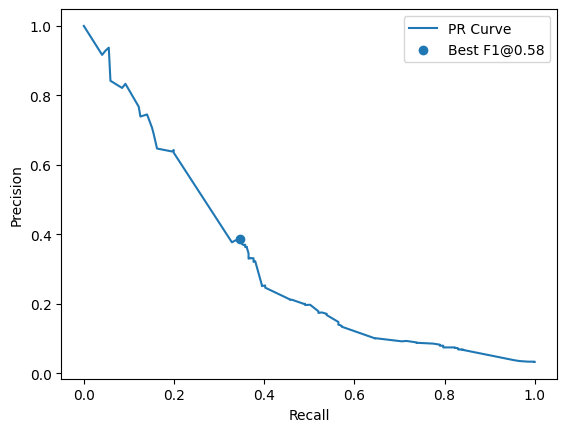

In [30]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx   = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1     = f1_scores[best_idx]

print(f"Optimal threshold: {best_thresh:.3f} → F1 = {best_f1:.3f}")

# Compare default vs optimized
for name, preds in [('Default (0.5)', y_proba>=0.5), ('Optimized', y_proba>=best_thresh)]:
    print(f"\n{name}:")
    print(classification_report(y_test, preds.astype(int), target_names=['No CIN','CIN']))

# Plot PR curve
plt.plot(recalls, precisions, label='PR Curve')
plt.scatter(recalls[best_idx], precisions[best_idx], label=f'Best F1@{best_thresh:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()

The optimal threshold for this model and data was found to be at 0.58. Non-CIN classfication remained strong. From the default model, the CIN precision increased from 0.25 to 0.39, showing this tuned model is much better at identifying CIN cases.

## Feature importance

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 10 features by importance (without Attendance):
Gender_Female                                   903
FSM_FSM_Eligible                                881
Year_Year 11                                    589
SEN_No SEN                                      542
Year_Year 7                                     499
Year_Year 8                                     452
Year_Year 10                                    420
Year_Year 9                                     411
Ethnicity_White - White British                 392
Ethnicity_White - Any other White background    319
dtype: int32


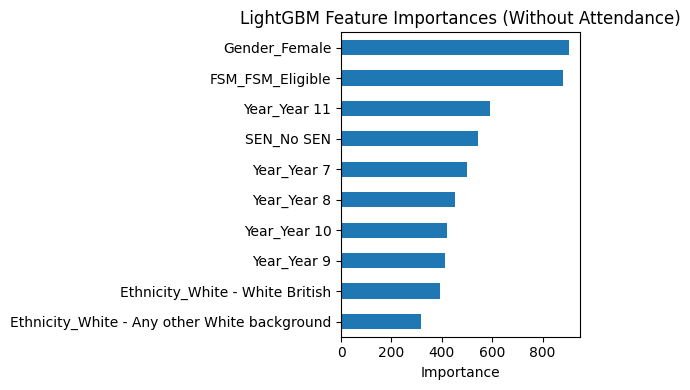

In [31]:
# Reconstruct attrubute list
feature_names = list(ohe.get_feature_names_out(cat_cols))

# Refit evaluated model
lgb_full = LGBMClassifier(
    n_estimators=300,
    is_unbalance=True,
    random_state=42,
    verbose=-1,
    log_level='error'
)
lgb_full.fit(X_train_pre, y_train)

# Sort importance
importances = pd.Series(lgb_full.feature_importances_, index=feature_names)
top10 = importances.sort_values(ascending=False).head(10)

print("Top 10 features by importance (without Attendance):")
print(top10)

# Plot
plt.figure(figsize=(6,4))
top10.sort_values().plot(kind='barh')
plt.title("LightGBM Feature Importances (Without Attendance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


### Feature Importance Comments

Without attendance the reliance of attributes shifts to a broader mix of the remaining attributes.

Overall, this balanced profile indicated the model is learning from multiple student characteristics not just one single proxy.